In [1]:
import phoebe
from phoebe import u, c

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 6)

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

In [10]:
b = phoebe.load("../estimations/aviles-data-bundle-saves/ebai-estimates")

In [11]:
# loading full Iturbide observations to compare results
import pandas as pd

OBJ_DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data"
CONCAT_OBSERVATIONS_CSV = f"{OBJ_DATA_DIR}/culledObjData.csv"
iturbideObservations = pd.read_csv(CONCAT_OBSERVATIONS_CSV, index_col=0)

b.add_dataset('lc', dataset='lc_iturbide_full_raw', overwrite=True,
              times=iturbideObservations['julianDate'].to_numpy()*u.day, 
              fluxes=iturbideObservations['FLUX'].to_numpy(), sigmas=iturbideObservations['FERR'].to_numpy(),
			  pblum_mode="dataset-scaled")

<ParameterSet: 47 parameters | contexts: figure, constraint, dataset, compute>

In [27]:
rawGaiaDatasets = [d for d in b.datasets if 'raw' in d and 'gaia' in d]
allRawDatasets = rawGaiaDatasets + ['lc_iturbide_raw', 'lc_iturbide_full_raw']
rawOptDatasets = rawGaiaDatasets + ['lc_iturbide_raw']

plotAllDatasetsGroups = [['lc_iturbide_raw'], ['lc_iturbide_full_raw'], rawGaiaDatasets]

def printChi2(b: phoebe.Bundle, model: str):
	print(model, "-------------------------------------", sep='\n')
	try:
		print('\t', "Iturbide (Aviles) -", np.sum(b.calculate_chi2(model=model, dataset='lc_iturbide_raw')))
	except: pass

	try:
		print('\t', "Iturbide (Full) -", np.sum(b.calculate_chi2(model=model, dataset='lc_iturbide_full_raw')))
	except: pass

	try:
		print('\t', "Gaia -", np.sum(b.calculate_chi2(model=model, dataset=rawGaiaDatasets)))
	except: pass

	try:
		for gd in rawGaiaDatasets:
			print('\t\t', gd, "-", np.sum(b.calculate_chi2(model=model, dataset=gd)))
	except: pass

def printAllModelsChi2(b: phoebe.Bundle):
	for m in b.models:
		printChi2(b, m)

100%|██████████| 1964/1964 [02:59<00:00, 10.93it/s]
Wed, 01 Nov 2023 00:48 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


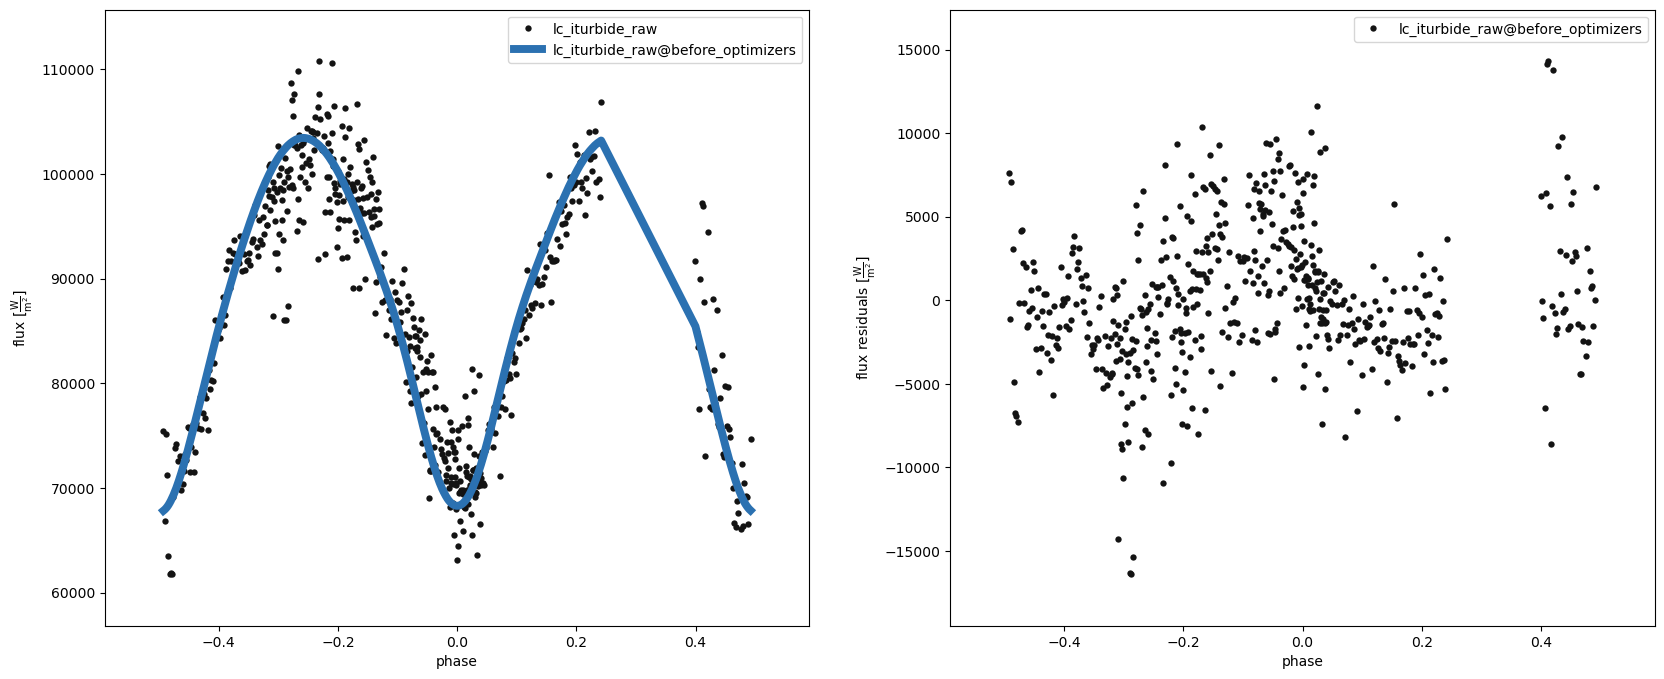

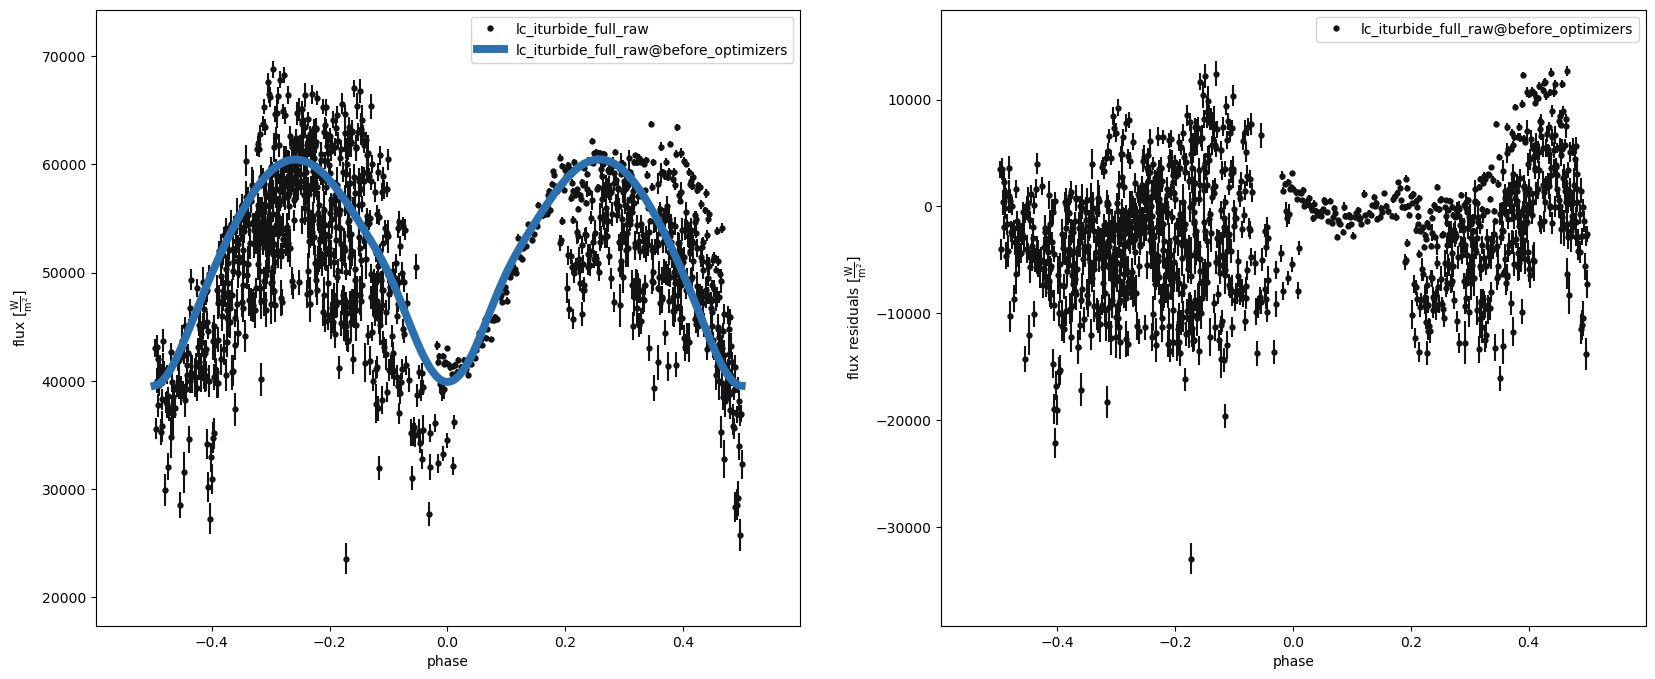

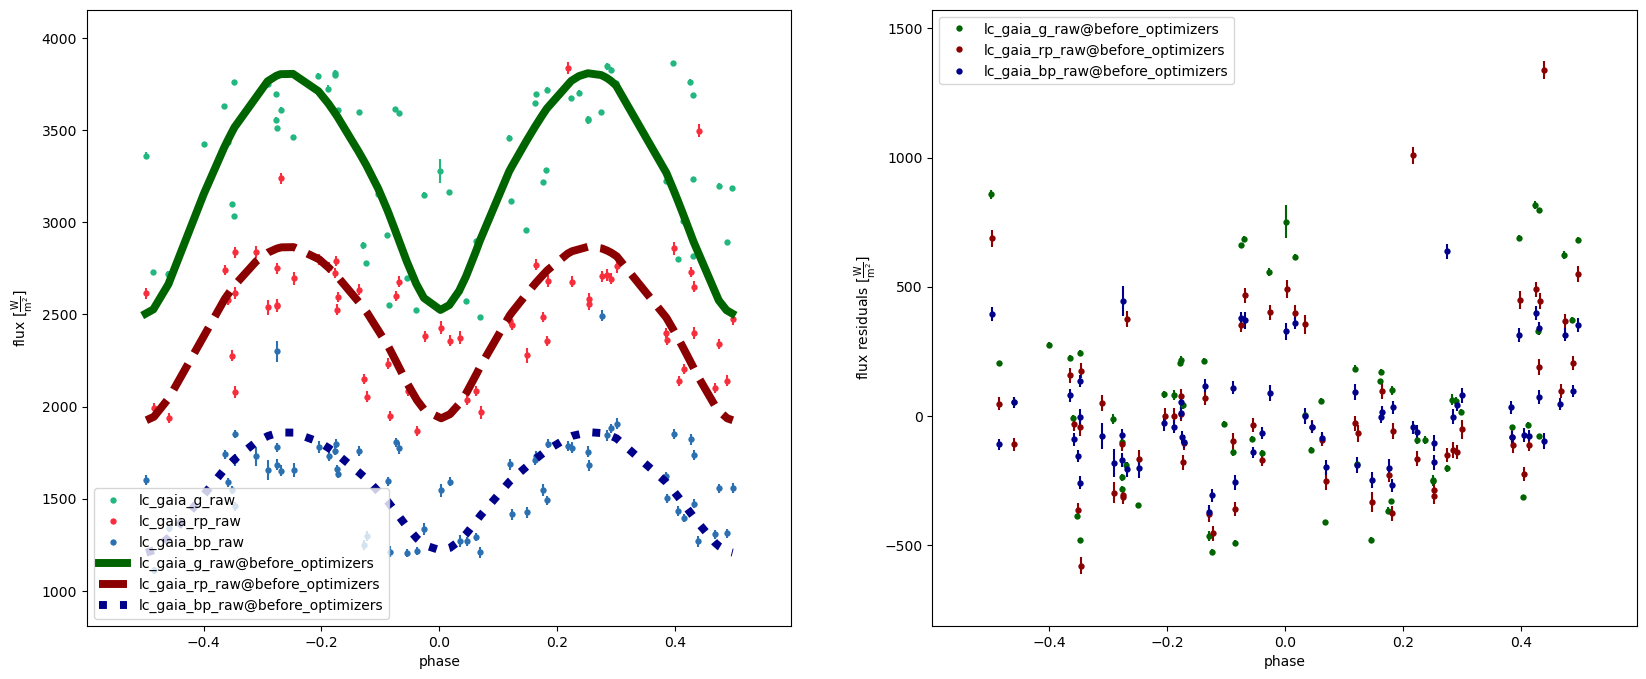

before_optimizers
-------------------------------------
	 Iturbide (Aviles) - 9878882142.08559
	 Iturbide (Full) - 65242.231795524516
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079


In [12]:
gen_utils.abilitateDatasets(b, allRawDatasets)
b.run_compute(model='before_optimizers', overwrite=True)

gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], ['lc_iturbide_full_raw'], rawGaiaDatasets], model='before_optimizers')
printChi2(b, "before_optimizers")

## Inverting `q`

Inverting the mass ratio to obtain lower mass components; will re-optimize parameters according to this new assumption.

Flipping `sma@binary` constraint to keep low estimated masses.

In [19]:
b.flip_constraint(qualifier='mass', component='primary', solve_for='sma@binary')

<ConstraintParameter: {sma@binary@component} = (((({mass@primary@component} * ({period@binary@component} ** 2.000000)) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218) / 39.478418) ** (1./3) (solar units) => 3.3499999999999996 solRad>

In [7]:
print(b['q'])
print(b['mass'])
print(b['sma@binary'])

Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 3.494945627992298
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, mass@primary@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@secondary@component, requiv_max@secondary@component, requiv_min@secondary@component
                      Related to: pot@contact_envelope@component, sma@binary@component, requiv@primary@component, requiv@secondary@component, fillout_factor@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, period@binary@component, mass@primary@component, sma@primary@component, incl@bin

Wed, 01 Nov 2023 00:50 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@primary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Wed, 01 Nov 2023 00:50 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
100%|██████████| 1964/1964 [02:53<00:00, 11.34it/s]
Wed, 01 Nov 2023 00:54 BUNDL

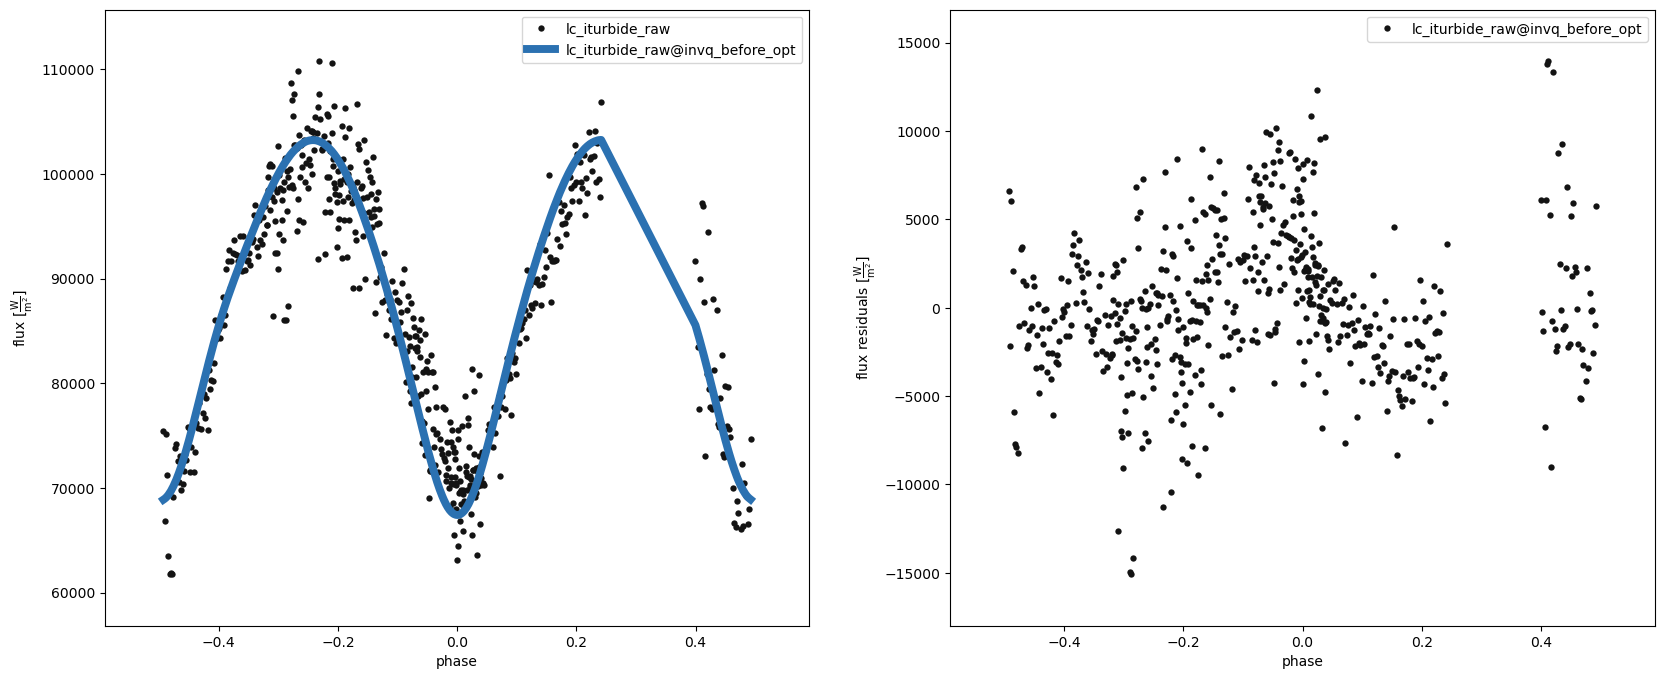

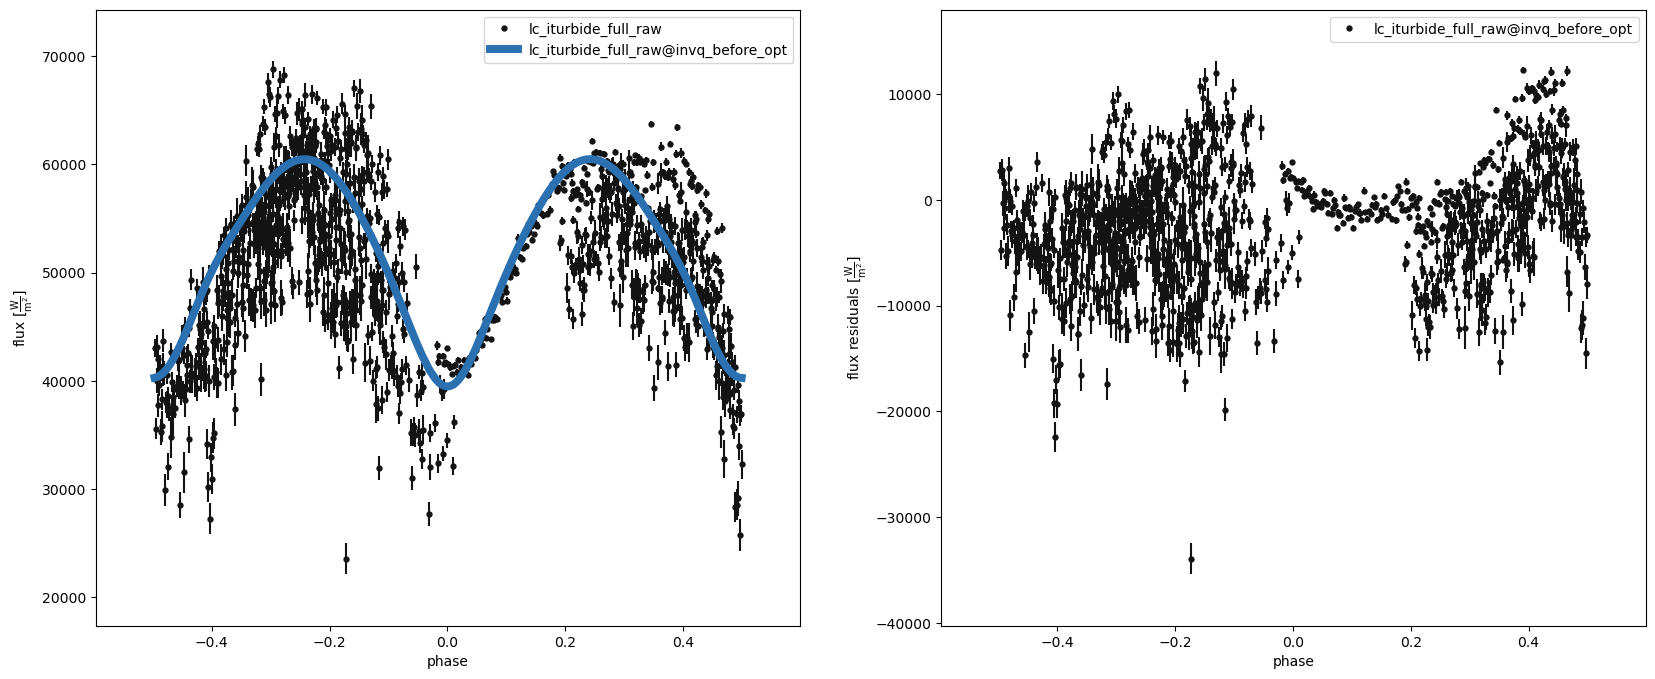

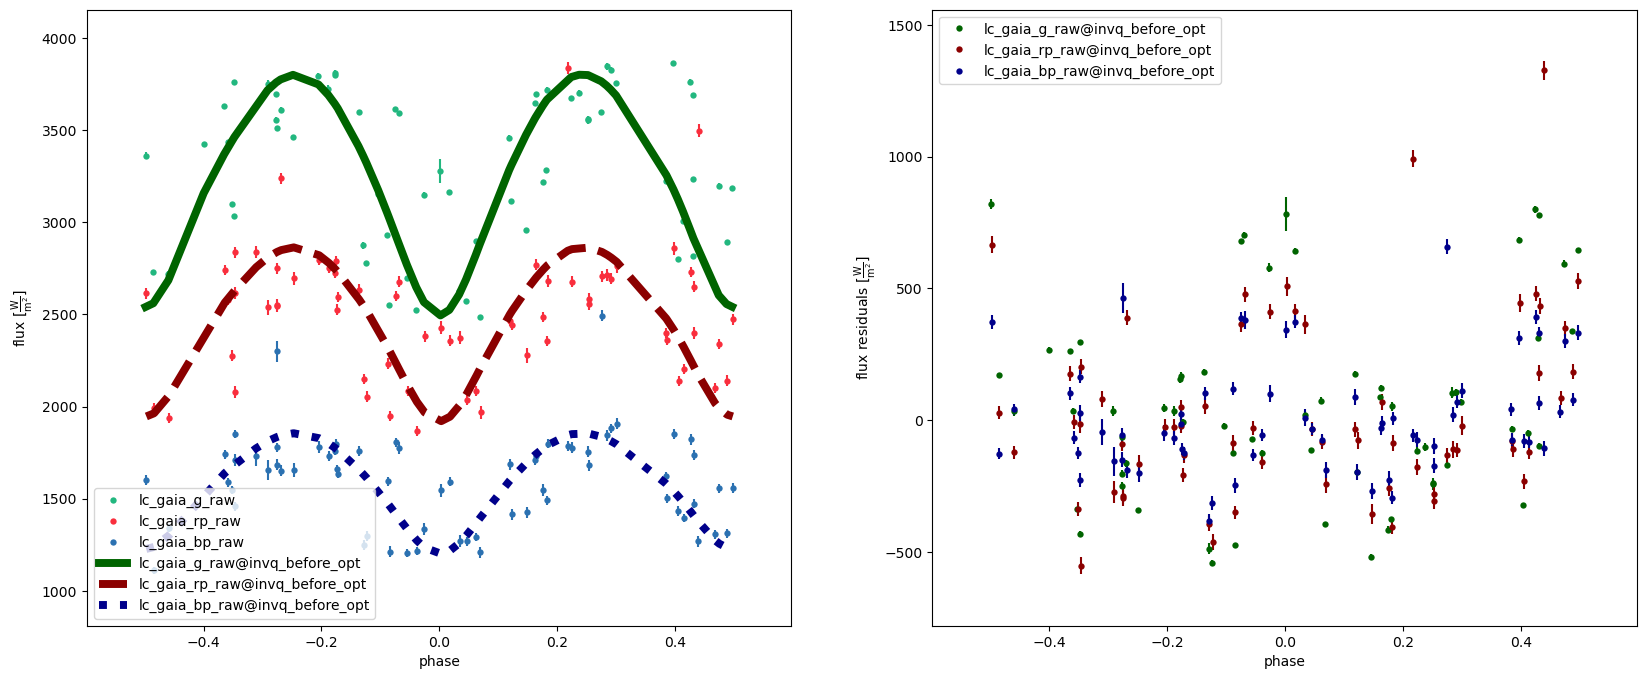

before_optimizers
-------------------------------------
	 Iturbide (Aviles) - 9878882142.08559
	 Iturbide (Full) - 65242.231795524516
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079
invq_before_opt
-------------------------------------
	 Iturbide (Aviles) - 9975101757.293251
	 Iturbide (Full) - 65205.83724771587
	 Gaia - 83847.42239053102
		 lc_gaia_g_raw - 72394.40785348201
		 lc_gaia_rp_raw - 7697.984489788328
		 lc_gaia_bp_raw - 3755.0300472606714


In [20]:
b.set_value(qualifier='q', value=1/b.get_value(qualifier='q'))
b.run_compute(model='invq_before_opt', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, (20, 8), [['lc_iturbide_raw'], ['lc_iturbide_full_raw'], rawGaiaDatasets], model="invq_before_opt")

printChi2(b, "before_optimizers")
printChi2(b, "invq_before_opt")

In [21]:
print(b['q'])
print(b['mass'])
print(b['sma@binary'])

Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 0.2861274842133835
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@secondary@component, requiv_max@secondary@component, requiv_min@secondary@component
                      Related to: pot@contact_envelope@component, sma@binary@component, requiv@primary@component, requiv@secondary@component, fillout_factor@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@primary@component, incl@binary@component, asini@primary@component, requiv_max@primary@component, re

## Poro et al. (2021) Priors

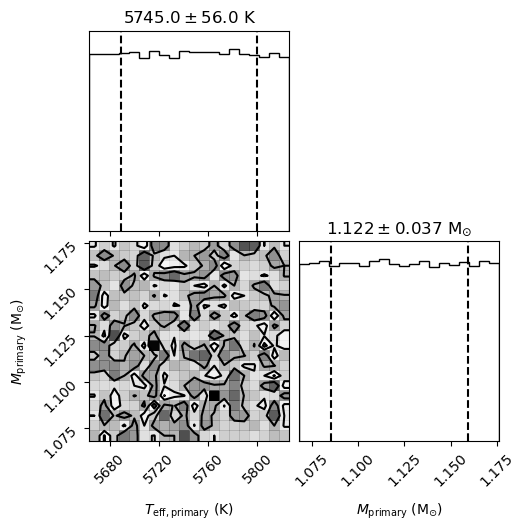

In [22]:
# Poro et al. (2021) [Investigation of P_orb and other params relationships]
# using uninformative uniform priors; mainly looking to restrict optimizer parameter space
p_orb = b.get_value(qualifier='period', component='binary')

# primary T_eff
upperTeffPrimary = (6951.42 + 112.16)*p_orb + (3426.01 + 44.12)
lowerTeffPrimary = (6951.42 - 112.68)*p_orb + (3426.01 - 43.90)

# primary mass
upperMassPrimary = (2.924 + 0.075)*p_orb + (0.147 + 0.029)
lowerMassPrimary = (2.924 - 0.075)*p_orb + (0.147 - 0.029)

b.add_distribution({
	'teff@primary': phoebe.uniform(high=upperTeffPrimary, low=lowerTeffPrimary, unit=u.K),
	'mass@primary': phoebe.uniform(high=upperMassPrimary, low=lowerMassPrimary, unit=u.solMass)
}, distribution='poro_porb_bounds', overwrite_all=True)

_ = b.plot_distribution_collection(distribution='poro_porb_bounds', show=True)

## Trimming the Bundle

Removing unused datasets and models from estimators to de-clutter bundle and decrease bundle size.

In [23]:
for m in b.models:
	if m.startswith('ebai'):
		b.remove_model(m)

for d in ['lc_iturbide', 'lc_gaia_g', 'lc_gaia_rp', 'lc_gaia_bp']:
	b.remove_dataset(d)

## Period and `t0_supconj`

Using solution from other optimizer, results should be about the same.

Adopted:
t0_supconj@binary@orbit@component = 0.07183 d
period@binary@orbit@component = 0.33354 d

Original values:
  t0_supconj@binary@orbit@component 0.06841024400254482 d
  period@binary@orbit@component 0.3335413827524847 d


100%|██████████| 1948/1948 [02:50<00:00, 11.45it/s]
Wed, 01 Nov 2023 01:06 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


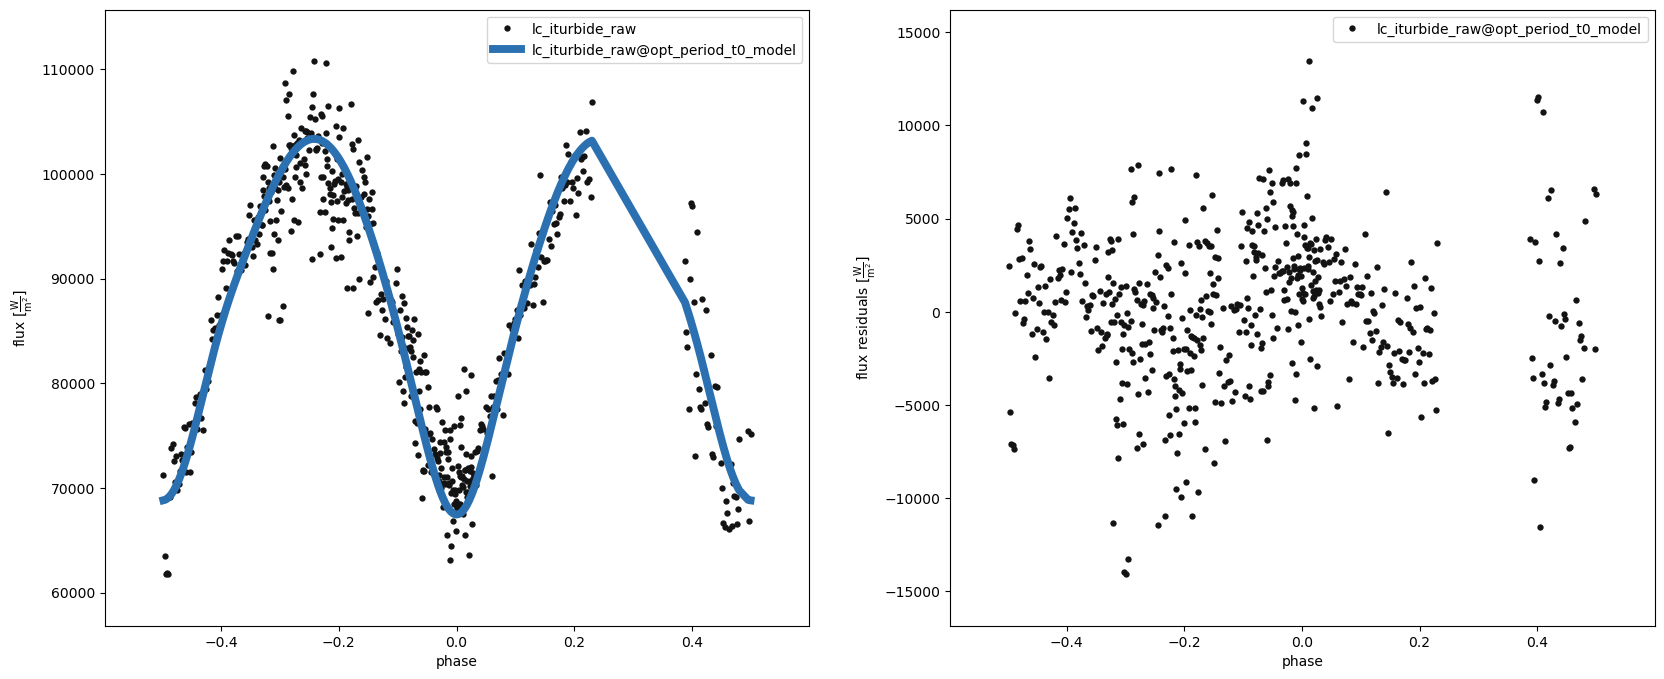

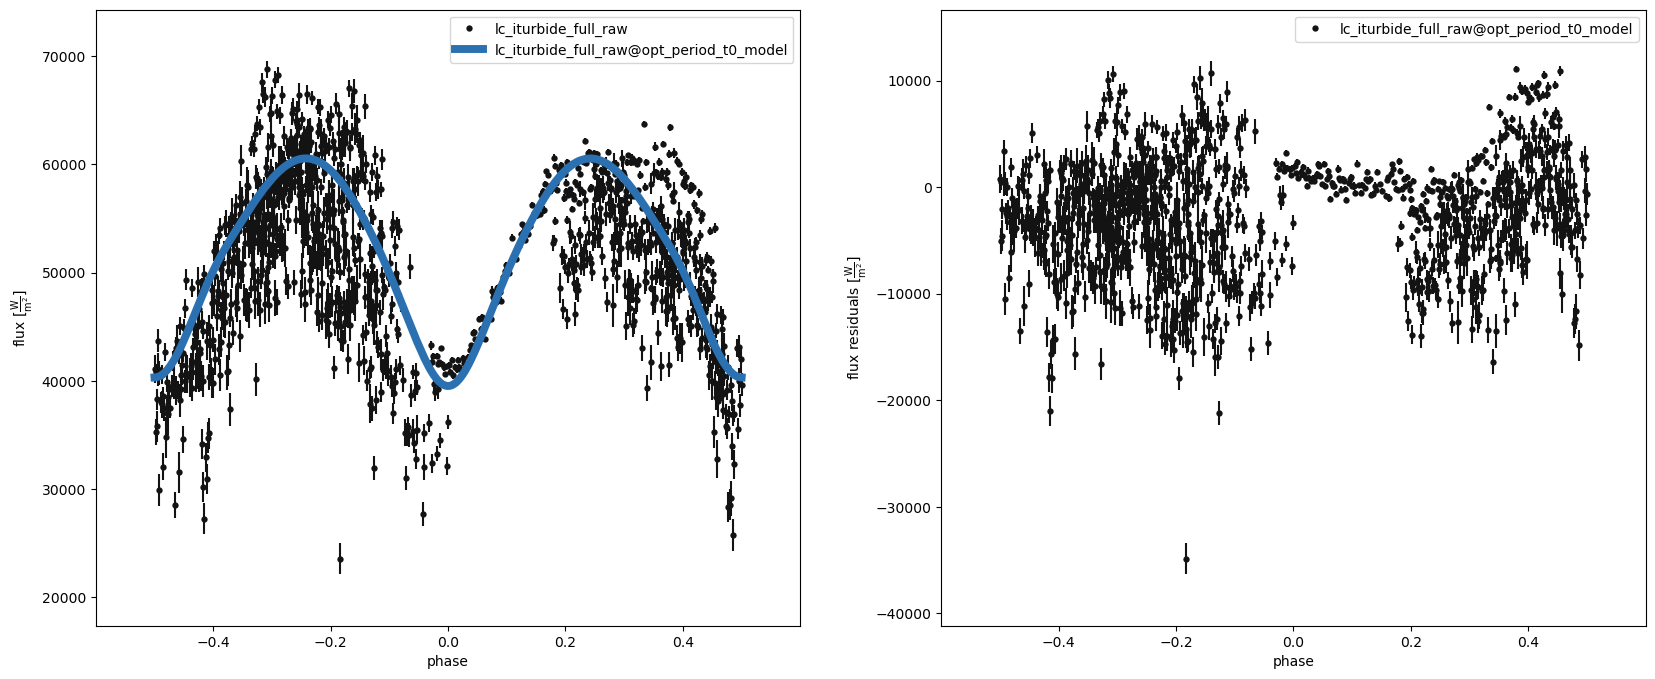

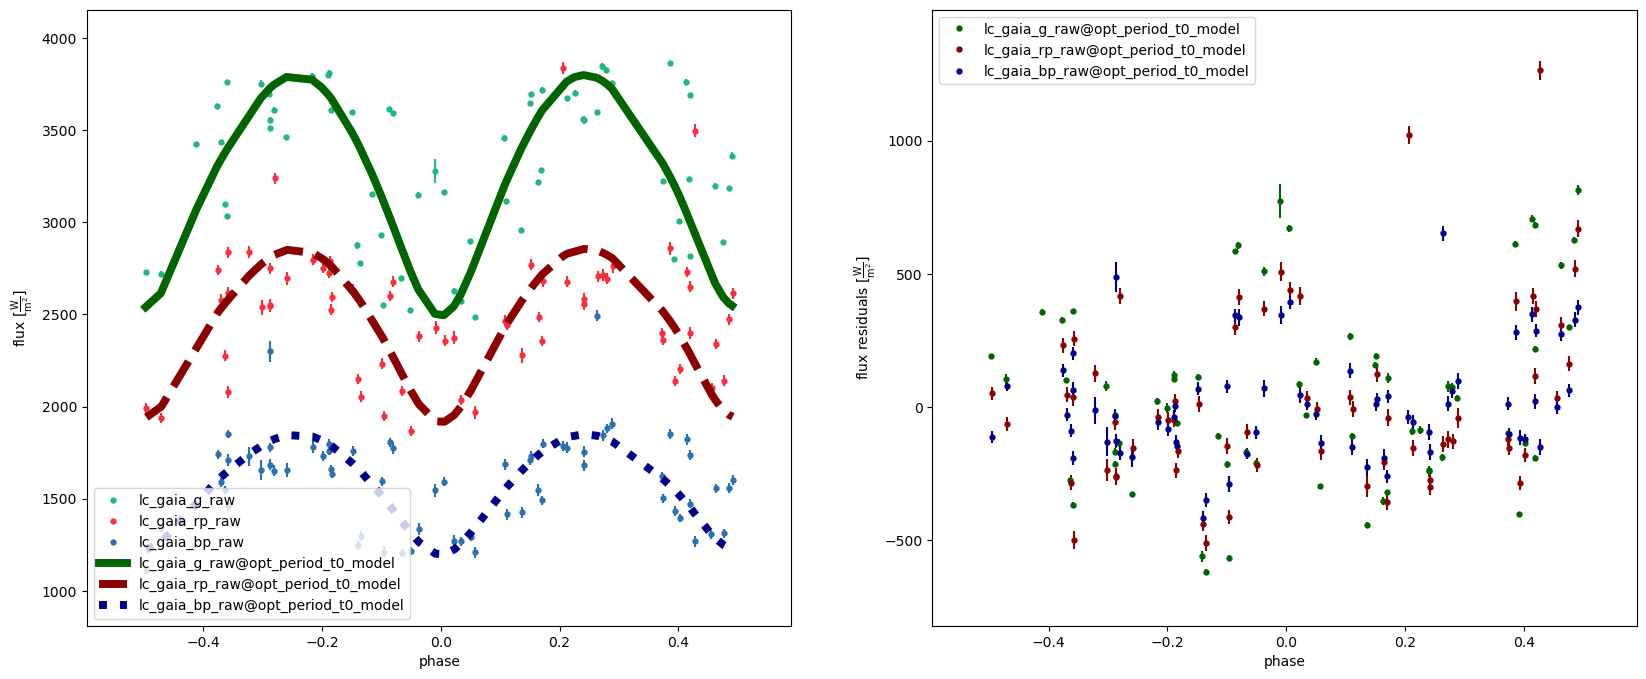

before_optimizers
-------------------------------------
	 Iturbide (Aviles) - 9878882142.08559
	 Iturbide (Full) - 65242.231795524516
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079
opt_period_t0_model
-------------------------------------
	 Iturbide (Aviles) - 8728113097.537786
	 Iturbide (Full) - 57452.416163874615
	 Gaia - 76249.39972445427
		 lc_gaia_g_raw - 65242.71478786489
		 lc_gaia_rp_raw - 7409.450191021206
		 lc_gaia_bp_raw - 3597.234745568175


In [24]:
solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, 
                                                          solution_file="./aviles-data-external-jobs/results/opt_period_t0_solution", plot=False, 
                                                          dataset=allRawDatasets)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], ['lc_iturbide_full_raw'], rawGaiaDatasets], model=computeModelName)
printChi2(b, 'before_optimizers')
printChi2(b, computeModelName)

## Width and depth of eclipses

First pass at optimizing `teffratio`. Optimizing `fillout_factor` to give depth of eclipses (parametrization of radii).

In [25]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], "teffr_ff", export=True, subfolder="poro-aviles-invq", datasets=rawOptDatasets, maxiter=1000)

External Solver: ./external-jobs/poro-aviles-invq/optimizer.nelder_mead_opt_teffr_ff.py ./results/opt_teffr_ff_solution


('opt_teffr_ff', 'opt_teffr_ff_solution')

## `q` and Inclination

Testing optimizing for mass ratio and system inclination.

In [26]:
opt_utils.optimize_params(b, ['q', 'incl@binary'], "q_incl", export=True, subfolder="poro-aviles-invq", datasets=rawOptDatasets, maxiter=1000)
opt_utils.optimize_params(b, ['incl@binary'], "incl", export=True, subfolder="poro-aviles-invq", datasets=rawOptDatasets, maxiter=1000)
opt_utils.optimize_params(b, ['q'], "q", export=True, subfolder="poro-aviles-invq", datasets=rawOptDatasets, maxiter=1000)

External Solver: ./external-jobs/poro-aviles-invq/optimizer.nelder_mead_opt_q_incl.py ./results/opt_q_incl_solution
External Solver: ./external-jobs/poro-aviles-invq/optimizer.nelder_mead_opt_incl.py ./results/opt_incl_solution
External Solver: ./external-jobs/poro-aviles-invq/optimizer.nelder_mead_opt_q.py ./results/opt_q_solution


('opt_q', 'opt_q_solution')

Adopted:
incl@binary@orbit@component = 68.77717 deg

Original values:
  incl@binary@orbit@component 71.94760460889874 deg


100%|██████████| 1964/1964 [02:31<00:00, 12.97it/s]
Wed, 01 Nov 2023 17:08 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


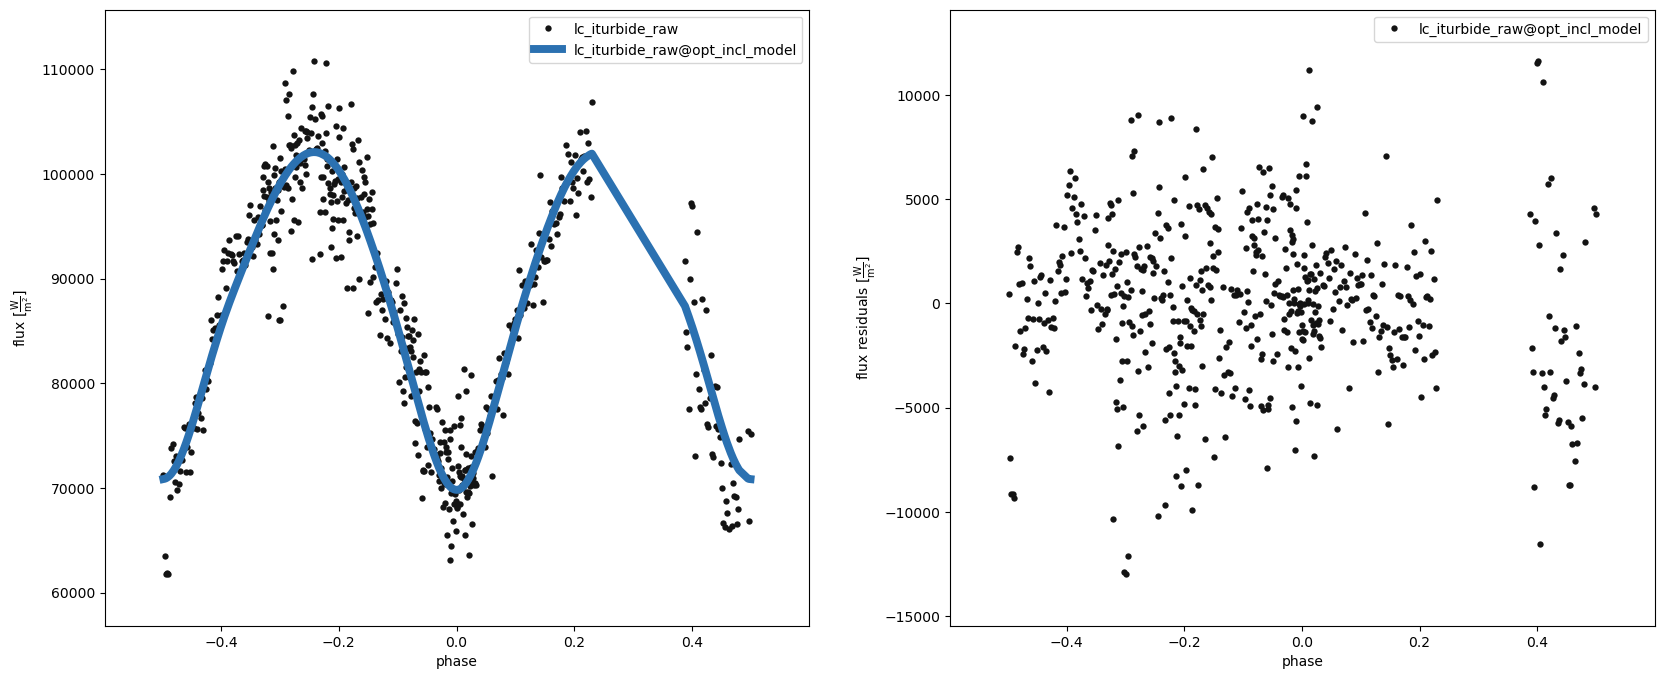

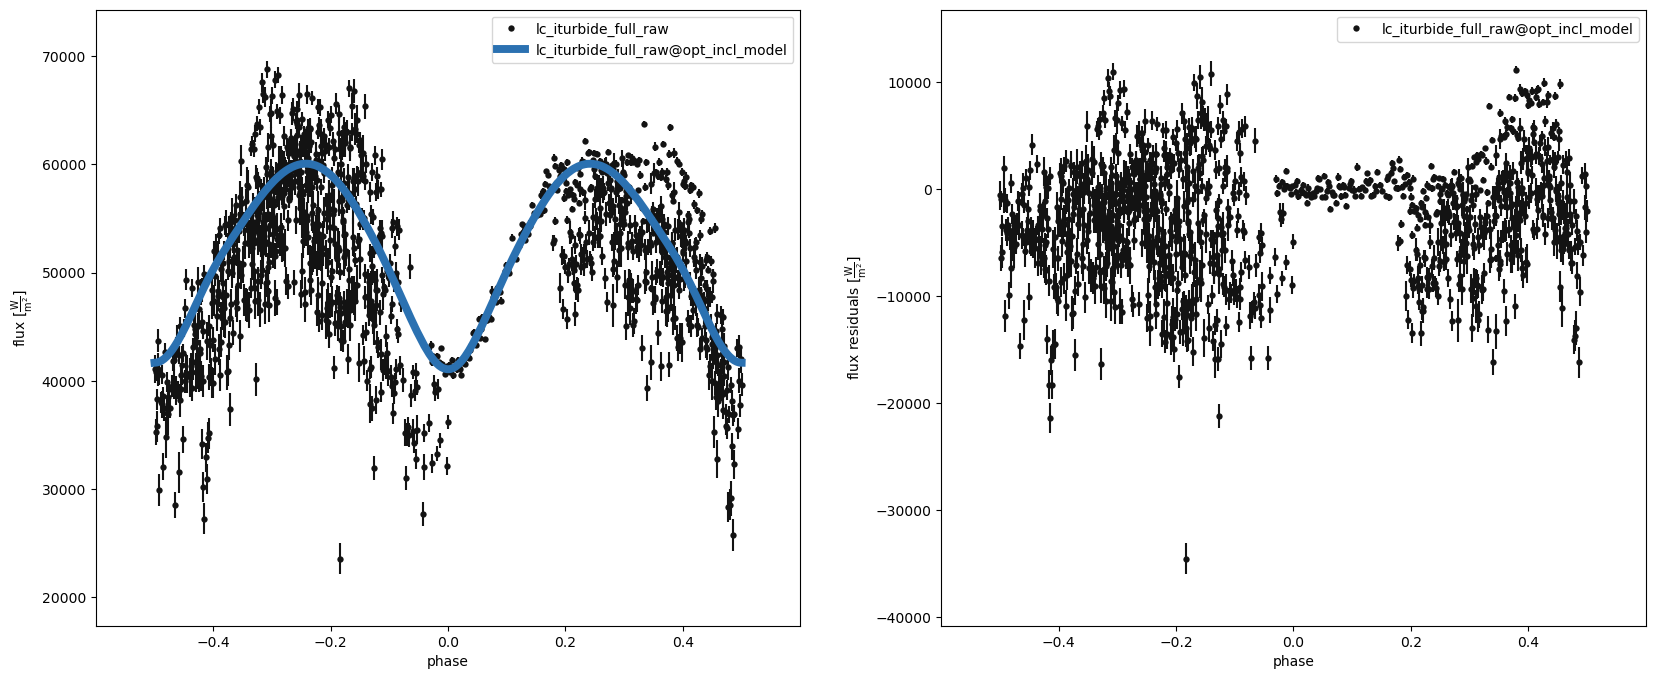

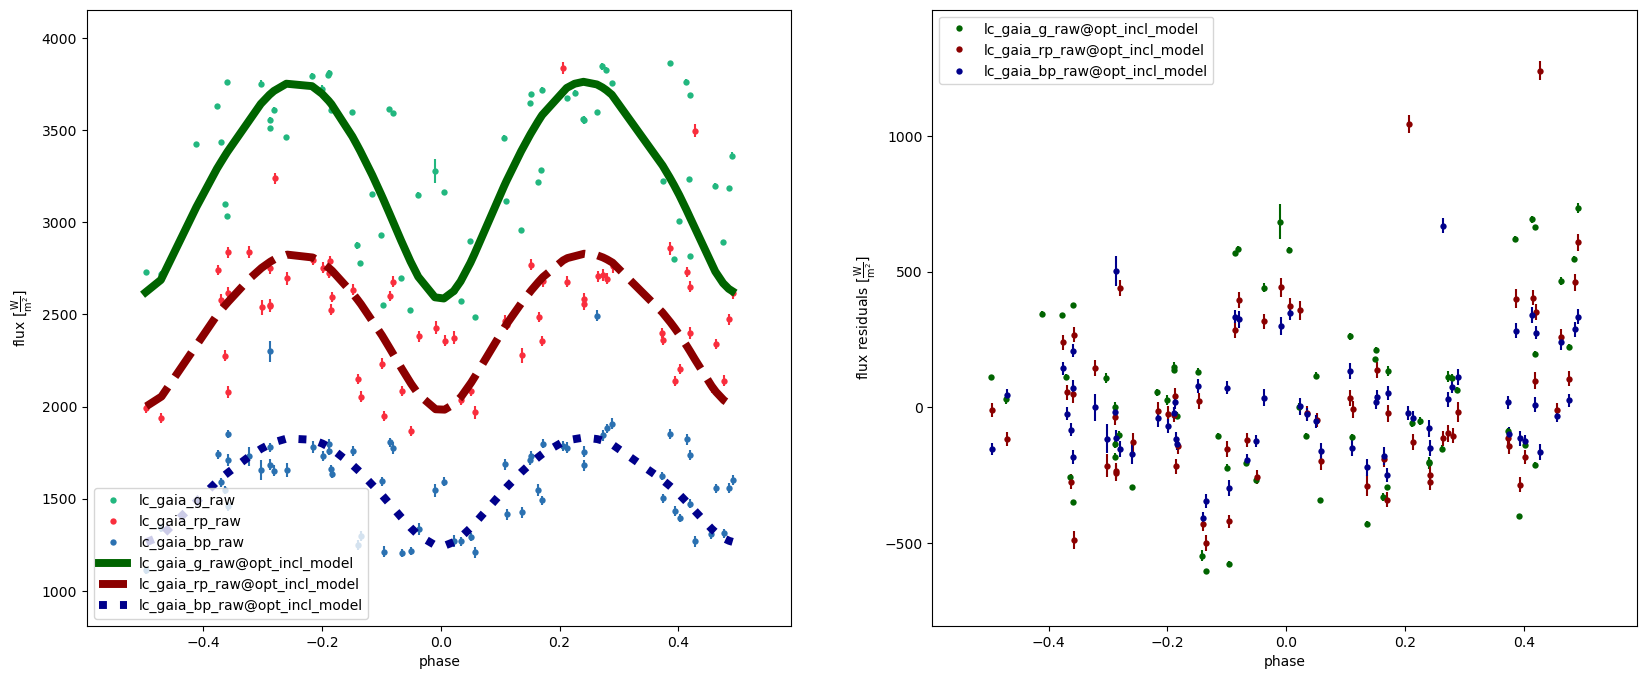

full_default
-------------------------------------
raw_model
-------------------------------------
	 Iturbide (Aviles) - 526346844631.68317
	 Gaia - 574823.2231559469
		 lc_gaia_g_raw - 499130.5358300727
		 lc_gaia_rp_raw - 45880.46343980033
		 lc_gaia_bp_raw - 29812.223886073876
before_optimizers
-------------------------------------
	 Iturbide (Aviles) - 9878882142.08559
	 Iturbide (Full) - 65242.231795524516
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079
invq_before_opt
-------------------------------------
	 Iturbide (Aviles) - 9975101757.293251
	 Iturbide (Full) - 65205.83724771587
	 Gaia - 83847.42239053102
		 lc_gaia_g_raw - 72394.40785348201
		 lc_gaia_rp_raw - 7697.984489788328
		 lc_gaia_bp_raw - 3755.0300472606714
opt_period_t0_model
-------------------------------------
	 Iturbide (Aviles) - 8728113097.537786
	 Iturbide (Full) - 57452.416163874615
	 Gaia - 76249.39972445427
		 lc_ga

In [28]:
# incl only
gen_utils.abilitateDatasets(b, allRawDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-aviles-invq/results/opt_incl_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20, 8), plotAllDatasetsGroups, model=computeModelName)
printAllModelsChi2(b)